In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16, vgg16_bn, resnet18, resnet34, resnet50, resnet101, resnet152

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import f1_score

import seaborn as sn

from os import listdir, path
from PIL import Image
from collections import defaultdict
import csv
import re
import os

from IPython.display import display, clear_output, Image as IPython_Image

In [2]:
torch.cuda.is_available()

True

# Data loading

In [3]:
IMAGE_PATH = '../data/images'
LABEL_PATH = '../data/annotations'

# GIVEN DATASET
MEAN = (0.43672, 0.40107, 0.36762)
STD = (0.30139, 0.28781, 0.29236)

# IMAGENET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)

# RESNET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)
       
# Define default pos_weights for nn.BCEWithLogitsLoss(pos_weights).
label_pos_weights_for_loss = np.array([209.52631579, 55.87203791, 58.40594059, 16.77777778, 44.80152672, 5.25, 25.14379085, 5.75675676, 33.09090909, 2.15540363, 5.51465798, 163.38356164, 119., 37.46153846], dtype=np.float32)

In [4]:
def number_of_classes():
    return len(listdir(LABEL_PATH))

In [5]:
def get_class_map():
    ret = {}

    i = 0
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        ret[img_class] = i
        i += 1

    return ret

In [6]:
def write_labels_to_csv(name_of_set, label_array):
    filepath = f'../data/labels_{name_of_set}.csv'
    
    label_arr = np.array(label_array).astype(int)

    # Save 2D numpy array to csv file
    np.savetxt(filepath, label_arr, delimiter=',', fmt='%d')

In [7]:
def get_data(train_fr=.6, max_images_per_class=1e9):
    # mapping from class names to integers
    class_map = get_class_map()

    # create a dictionary to hold our label vectors
    n_classes = len(class_map.keys())
    img_to_class = defaultdict(lambda: np.zeros(n_classes))

    # another dictionary to hold the actual image data
    img_to_data = dict()
    
    # loop through all the annotations
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        print(f'Reading class: {img_class}')
        
        # open the annotation file
        i = 0
        with open(f'{LABEL_PATH}/{fname}', 'r') as fh:

            # get image ids from annotation file
            img_ids = fh.read().splitlines()
            
            # gather the images with labels
            for i, img_id in enumerate(img_ids):
                
                # let's not process images unnecessarily
                if not img_id in img_to_data:

                    img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                    img = Image.open(img_path)

                    # append to dict
                    img_to_data[img_id] = img.convert('RGB')

                # get one-hot encoded vector of image classes
                img_classes = img_to_class[img_id]

                # add new class to image vector
                img_class_id = class_map[img_class]
                img_classes[img_class_id] = 1

                # store the updated vector back
                img_to_class[img_id] = img_classes

                if i >= max_images_per_class:
                    break

                i += 1

    # load also all the images that do not have any labels
    i = 0
    print(f'Reading images without labels..')
    for fname in listdir(IMAGE_PATH):
        m = re.match('im(\d+)', fname)
        img_id = m.group(1)

        if img_id not in img_to_data:
            img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
            img = Image.open(img_path)

            # append to dict
            img_to_data[img_id] = img.convert('RGB')

            if i >= max_images_per_class:
                break

            i += 1

    print('Creating train/valid/test split..')
    # collect data to a single array
    X = []
    y = []
    for img_id in img_to_data.keys():
        X.append(img_to_data[img_id])
        y.append(img_to_class[img_id])

    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, train_size=train_fr, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp, train_size=.5, test_size=.5, random_state=42)
    
    print('Done.')

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [8]:
class TransformingDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_data = self.X[idx]
        img_class = self.y[idx]

        if transforms:
            img_data = self.transforms(img_data)

        return img_data, img_class

# Models

In [9]:
class TwoLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        self.bs = bs
        self.input_layer = nn.Linear(n_input, n_hidden1)
        self.hidden1 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden2 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.hidden2(x)

        return x

In [10]:
class OneLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes):
        super().__init__()

        self.input_layer = nn.Linear(n_input, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden)

    def forward(self, x):
        print(f'X.SHAPE: {x.shape}')
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden(x)

        return x

In [11]:
class ConvNetModel(nn.Module):
    def __init__(self, n_classes, keep_prob=.5):
        super(ConvNetModel, self).__init__()
        # Common layers used multiple times
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=1-keep_prob)
        
        # Unique layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=1) #(n samples, channels, height, width)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=14, kernel_size=3, stride=1, padding=1)
        self.fc3 = nn.Linear(in_features=256*4*14, out_features=n_classes)
        
    def forward(self, x):
        x = x.reshape(-1, 3, 128, 128)
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = out.reshape(out.size(0), -1)  # Flatten for FC
        out = self.fc3(out)
        return out    

# Training and evaluation functions

In [12]:
def evaluate(dataloader, model, criterion, device, threshold=0.5):
    model.eval()

    f1_scores = []
    losses = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            losses.append(loss)

            with torch.no_grad():
                score = f1_score(y.cpu() == 1, y_pred.cpu() > threshold, average='micro')
                f1_scores.append(score)

    model.train()

    return torch.mean(torch.tensor(losses)), torch.mean(torch.tensor(f1_scores))

In [13]:
def train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=50, verbose=True):
    model.train()

    if verbose:
        fmt = '{:<5} {:12} {:12} {:<9} {:<9}'
        print(fmt.format('Epoch', 'Train loss', 'Valid loss', 'Train F1', 'Valid F1'))

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            print(f'Epoch: {epoch+1}, iteration: {i+1}, loss: {loss}')

        if verbose:
            train_loss, train_score = evaluate(train_dataloader, model, criterion, device)
            valid_loss, valid_score = evaluate(valid_dataloader, model, criterion, device)

            fmt = '{:<5} {:03.10f} {:03.10f} {:02.7f} {:02.7f}'
            print(fmt.format(epoch, train_loss, valid_loss, train_score, valid_score))
            
    print('Done training!')

In [14]:
def visualize_predictions(model, device, dataloader, mean=MEAN, std=STD, n_to_show=3, threshold=0.5):
    
    class_to_label = { v: k for k, v in get_class_map().items() }
    
    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/5
    inv_transform = transforms.Compose([
        transforms.Normalize(mean = -1 * np.multiply(mean, std), std=np.divide(1, std))
    ])
    
    n_shown = 0
    for i, batch in enumerate(dataloader):        
        X, y = batch
        X = X.to(device)

        y_pred_raw = model(X).cpu()
        y_pred = y_pred_raw > threshold 
        y = y == 1

        for i in range(len(y)):
            pred_classes = np.where(y_pred[i] == 1)[0]
            true_classes = np.where(y[i] == 1)[0]
            
            true_classes_str = ', '.join([class_to_label[i] for i in true_classes])
            pred_classes_str = ', '.join([class_to_label[i] for i in pred_classes])

            img = inv_transform(X[i].cpu())              # inverse transforms
            img = img.permute(2, 1, 0)                   # BGR -> RGB
            img = np.rot90(img, 3)
                                    
            plt.title(f'True: {true_classes_str}, Predictions: {pred_classes_str}')
            plt.imshow(img)
            plt.pause(0.001)

            n_shown += 1
            
            if n_shown >= n_to_show:
                return            

It would be nice to use same naming conventions everywhere. Might be a good idea to rename `y_hat` to `y_pred` or vice versa everywhere (it makes it easier to combine the notebooks). I don't care which way it is. Also the `Xs` and `ys` etc.

In [15]:
def predict_X(fr, threshold=0.5):
    
    y_hat = fr > threshold
    
    return y_hat if (np.sum(y_hat) > 0) else fr == np.max(fr)

def predict(model, device, dataloader):
    
    ys_all = []  # Array of np.array(14) 
    y_hats_all = []
    
    for i, batch in enumerate(dataloader):
        
        Xs, ys = batch
        Xs = model(Xs.to(device))
        y_hats = np.apply_along_axis(predict_X, axis=1, arr=Xs.cpu().detach().numpy())
        
        y_hats_all.extend(y_hat for y_hat in y_hats)
        ys_all.extend(y.numpy() for y in ys==1)

    return np.array(ys_all), np.array(y_hats_all)

def visualize_confusion_matrix(y_true, y_pred, labels, file_path):

    plt.ioff()
    
    # Get confusion matrices
    cn_tensor = skm.multilabel_confusion_matrix(y_true, y_pred)
    
    # Get precision, recall, f1-score
    scores = skm.classification_report(y_true, y_pred, output_dict=True)

    fig, ax = plt.subplots(nrows=5, ncols=3,sharey=True, figsize=(20, 20), 
                           gridspec_kw={'hspace': 0.3, 'wspace': 0.0})
    gn = ['True Neg','False Pos','False Neg','True Pos']
    n = cn_tensor[0].sum()
    
    # Loop all labels
    for i, cn_matrix in enumerate(cn_tensor):

        j, k = int(i/3), i%3
        
        # Annotations
        annot = np.asarray(
            ['{}\n{:0.0f}\n{:.2%}'.format(gn[i], x, x/n) for i, x in enumerate(cn_matrix.flatten())]
        ).reshape(2,2)
        
        # Plot heatmap
        sn.heatmap(cn_matrix, annot=annot, fmt='', cmap='Blues', ax=ax[j, k])
        
        # Precision, recall, f1-score
        title = '{}\nprec.={:.3}, rec.={:.3}, f1={:.3}'.format(
            labels[i], scores[str(i)]['precision'], scores[str(i)]['recall'], scores[str(i)]['f1-score'])
        ax[j, k].set_title(title)
        
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()

# Do the magic!

In [16]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

lr = 0.01
n_epochs = 1
bs = 64
n_classes = len(get_class_map().keys())

Using GPU!


## Create and save / load dataloaders from disk

In [17]:
max_images_per_class = int(1e9)
#max_images_per_class = 200

transformations = {
    'train': transforms.Compose([
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((-10, 10)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
            transforms.RandomGrayscale(p=1),
            transforms.RandomPerspective(),
        ], p=0.5),
        transforms.ToTensor(),                
        transforms.Normalize(mean=MEAN, std=STD)            
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
}

if not os.path.isfile(f'X_train_n{max_images_per_class}.dat'):
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_data(max_images_per_class=max_images_per_class)
    torch.save(X_train, f'../data/X_train_n{max_images_per_class}.dat')
    torch.save(X_valid, f'../data/X_valid_n{max_images_per_class}.dat')
    torch.save(X_test, f'../data/X_test_n{max_images_per_class}.dat')
    torch.save(y_train, f'../data/y_train_n{max_images_per_class}.dat')
    torch.save(y_valid, f'../data/y_valid_n{max_images_per_class}.dat')
    torch.save(y_test, f'../data/y_test_n{max_images_per_class}.dat')
else:
    X_train = torch.load(f'../data/X_train_n{max_images_per_class}.dat')
    X_valid = torch.load(f'../data/X_valid_n{max_images_per_class}.dat')
    X_test = torch.load(f'../data/X_test_n{max_images_per_class}.dat')
    y_train = torch.load(f'../data/y_train_n{max_images_per_class}.dat')
    y_valid = torch.load(f'../data/y_valid_n{max_images_per_class}.dat')
    y_test = torch.load(f'../data/y_test_n{max_images_per_class}.dat')

train_dataloader = DataLoader(
    TransformingDataset(X_train, y_train, transforms=transformations['train']),
    shuffle=True,
    batch_size=bs)

valid_dataloader = DataLoader(
    TransformingDataset(X_valid, y_valid, transforms=transformations['valid']),
    shuffle=True,
    batch_size=bs)

test_dataloader = DataLoader(
    TransformingDataset(X_test, y_test, transforms=transformations['test']),
    shuffle=True,
    batch_size=bs)

Reading class: river
Reading class: clouds
Reading class: baby
Reading class: car
Reading class: dog
Reading class: bird
Reading class: flower
Reading class: male
Reading class: portrait
Reading class: tree
Reading class: night
Reading class: female
Reading class: people
Reading class: sea
Reading images without labels..
Creating train/valid/test split..
Done.


## Pretrained models

NB: The mean and std in transformations most probably need to be the same as for VGG and RESNET. Not 100% sure about this. Something to investigate!

More models here: https://pytorch.org/docs/stable/torchvision/models.html

If the models do not start to converge, try lowering the learning rate!

_VGG16_

Currently getting validation f1 scores around 0.67. 

Now around 0.71 with one cycle policy.

Surprisingly after quick testing the vgg16_bn (with BatchNorm layers) did not do as well? Maybe more to investigate here.

In [18]:
if True:
    model = vgg16(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Linear(2048, 14),
    ).to(device)

_RESNET_


In [19]:
if False:
    model = resnet18(pretrained=True).to(device)

    #for layer in model.children():
    #    layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [20]:
if False:
    model = resnet34(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [21]:
if False:
    model = resnet50(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

In [22]:
if False:
    model = resnet101(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

In [23]:
if False:
    model = resnet152(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

## Train a model or load an existing model from disk

In [24]:
# loss function
pos_weight = torch.from_numpy(label_pos_weights_for_loss).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# learning rate and momentum will be overriden by the scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    base_momentum=0.5,
    max_momentum=0.99,
    steps_per_epoch=len(train_dataloader),
    epochs=n_epochs,
)

In [25]:
# Paths for model saving and loading

# Only state dictionary
#model_save_path = '../data/resnet-valid-acc-aug-0.70.pth'
#model_save_path = '../data/resnet-101-valid-acc-0.73.pth'
#model_save_path = '../data/resnet-valid-acc-aug-0.716.pth'
#model_save_path = '../data/vgg16-9epochs-valid-acc-0.66.pth'

# Whole model
#model_whole_save_path = '../data/vgg16-7epochs-valid-acc-0.703.pth'

In [26]:
# Plain model saving and loading (only state dictionary).
#torch.save(model.state_dict(), model_save_path)
#model.load_state_dict(torch.load(model_save_path, map_location=torch.device(device)))

In [27]:
# Save an entire model (not just the state dict)
#torch.save(model, model_whole_save_path)

In [28]:
# Load an entire model (not just the state dict)
#model = torch.load(model_whole_save_path)
#model.eval()

In [29]:
# This is for trying to train all the layers...
#for param in model.parameters():
#    param.requires_grad = True

In [30]:
%time train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=n_epochs)

Epoch Train loss   Valid loss   Train F1  Valid F1 
Epoch: 1, iteration: 1, loss: 4.082390489824482
Epoch: 1, iteration: 2, loss: 3.7178603278517706
Epoch: 1, iteration: 3, loss: 4.341852213069292
Epoch: 1, iteration: 4, loss: 3.6363017771223487
Epoch: 1, iteration: 5, loss: 4.217873095019163
Epoch: 1, iteration: 6, loss: 3.071500905978305
Epoch: 1, iteration: 7, loss: 1.9929408298224702
Epoch: 1, iteration: 8, loss: 2.383613271395134
Epoch: 1, iteration: 9, loss: 2.045763926550932
Epoch: 1, iteration: 10, loss: 1.4854722035210097
Epoch: 1, iteration: 11, loss: 1.7098663204076556
Epoch: 1, iteration: 12, loss: 1.5198612136422218
Epoch: 1, iteration: 13, loss: 1.5686062619447074
Epoch: 1, iteration: 14, loss: 1.7169895796612262
Epoch: 1, iteration: 15, loss: 2.060070450251581
Epoch: 1, iteration: 16, loss: 2.0677639750216747
Epoch: 1, iteration: 17, loss: 2.2401872602950643
Epoch: 1, iteration: 18, loss: 2.104131857815552
Epoch: 1, iteration: 19, loss: 2.7409969005086467
Epoch: 1, itera

Epoch: 1, iteration: 164, loss: 1.0226163488516384
Epoch: 1, iteration: 165, loss: 1.0248696471318983
Epoch: 1, iteration: 166, loss: 0.8878535550153913
Epoch: 1, iteration: 167, loss: 1.0199832434771554
Epoch: 1, iteration: 168, loss: 0.8193973681109531
Epoch: 1, iteration: 169, loss: 0.9298381972229207
Epoch: 1, iteration: 170, loss: 0.855772647186431
Epoch: 1, iteration: 171, loss: 0.9729024286282746
Epoch: 1, iteration: 172, loss: 0.9012069790141659
Epoch: 1, iteration: 173, loss: 1.0045410268985149
Epoch: 1, iteration: 174, loss: 0.9149954444917976
Epoch: 1, iteration: 175, loss: 0.8509488319914402
Epoch: 1, iteration: 176, loss: 0.7537798032424302
Epoch: 1, iteration: 177, loss: 0.7424073562979863
Epoch: 1, iteration: 178, loss: 0.7995358855509759
Epoch: 1, iteration: 179, loss: 0.9902159863376763
Epoch: 1, iteration: 180, loss: 1.042901760767869
Epoch: 1, iteration: 181, loss: 0.8793512760449211
Epoch: 1, iteration: 182, loss: 0.8238907187260154
Epoch: 1, iteration: 183, loss: 0

In [31]:
evaluate(valid_dataloader, model, criterion, device, threshold=0.75)

(tensor(0.8717, dtype=torch.float64), tensor(0.4063, dtype=torch.float64))

threshold: 0.05, f1 score: 0.37944341129877096
threshold: 0.1, f1 score: 0.37979041349574255
threshold: 0.15000000000000002, f1 score: 0.38340116912184374
threshold: 0.2, f1 score: 0.3890433848257807
threshold: 0.25, f1 score: 0.3896661711042594
threshold: 0.3, f1 score: 0.39107936043594077
threshold: 0.35000000000000003, f1 score: 0.39512548584042834
threshold: 0.4, f1 score: 0.3980718474113675
threshold: 0.45, f1 score: 0.40086580950193323
threshold: 0.5, f1 score: 0.4041798704006662
threshold: 0.55, f1 score: 0.40705891374914777
threshold: 0.6000000000000001, f1 score: 0.4096768251200266
threshold: 0.6500000000000001, f1 score: 0.41310757817146637
threshold: 0.7000000000000001, f1 score: 0.41718461351223923
threshold: 0.7500000000000001, f1 score: 0.4207938147527324
threshold: 0.8, f1 score: 0.425198785522496
threshold: 0.8500000000000001, f1 score: 0.4280343383149589
threshold: 0.9000000000000001, f1 score: 0.4352247343763826
threshold: 0.9500000000000001, f1 score: 0.4413192647895

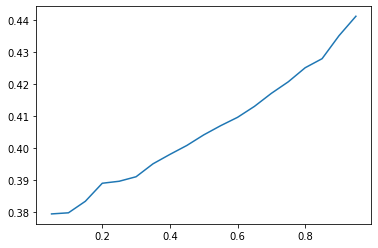

In [32]:
# This is for finding the optimal threshold.
# Haven't proved out to be very useful yet.
if True:
    f1_scores = []
    for threshold in np.arange(0.05, 1, 0.05):
        _, f1 = evaluate(valid_dataloader, model, criterion, device, threshold=threshold)
        f1_scores.append(f1)
        print(f'threshold: {threshold}, f1 score: {f1}')

    plt.plot(np.arange(0.05, 1, 0.05), f1_scores)

# Visualization and evaluation

### Show some images with predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


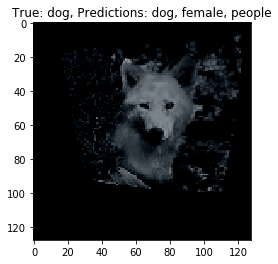

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


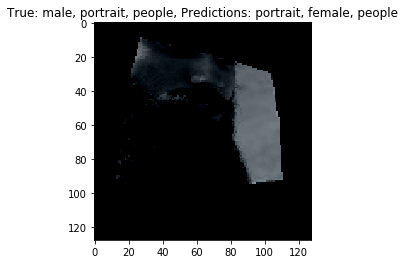

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


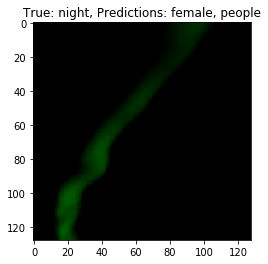

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


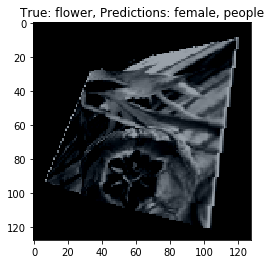

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


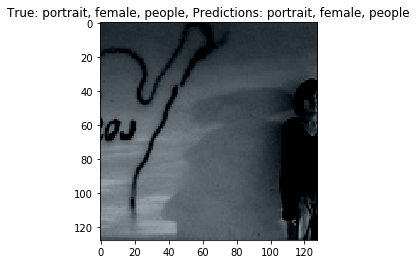

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


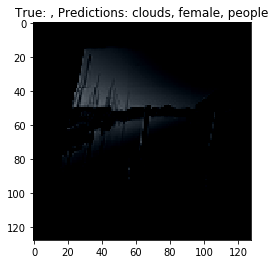

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


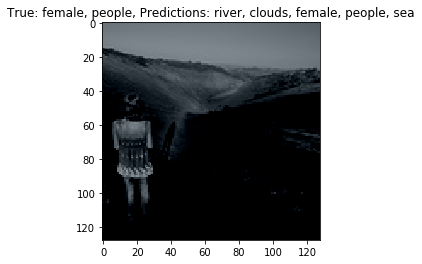

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


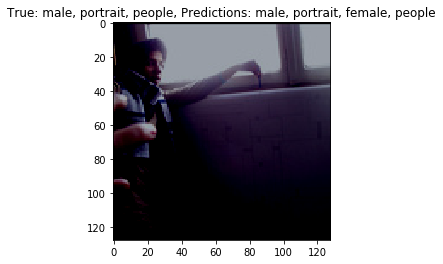

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


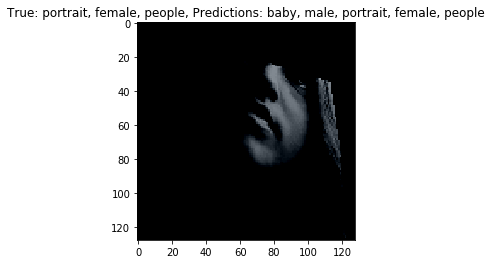

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


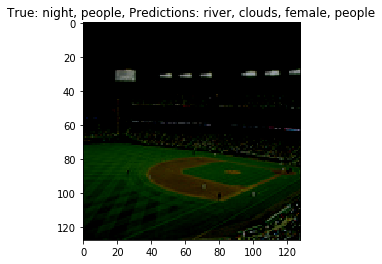

In [33]:
visualize_predictions(model, device, train_dataloader, n_to_show=10, threshold=0.75)

### Confusion matrix

In [36]:
re_predict = True

if re_predict:

    # Predict
    y_true, y_pred = predict(model, device, valid_dataloader)
    np.save(f'../data/valid_true_labels.npy', y_true)
    np.save(f'../data/valid_pred_labels.npy', y_pred)
    
    # Save classification report
    with open(f'../data/valid_classification_report.txt', 'w') as file:
        file.write(skm.classification_report(y_true, y_pred))
    
    # Save confusion matrix plot
    labels = [k for k, v in get_class_map().items()]
    visualize_confusion_matrix(y_true, y_pred, labels, f'../data/valid_confusion_matrix.png')

/home/akir/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/akir/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# Show classification report
with open(f'../data/valid_classification_report.txt', 'r') as file:
    report = ''.join(file.readlines())
    print(report)

              precision    recall  f1-score   support

           0       0.03      0.91      0.05        23
           1       0.18      0.98      0.30       213
           2       0.02      0.78      0.04         9
           3       0.76      0.53      0.62        74
           4       0.38      0.90      0.53        91
           5       0.00      0.00      0.00        77
           6       0.45      0.81      0.58       158
           7       0.46      0.70      0.56       614
           8       0.48      0.97      0.64       635
           9       0.00      0.00      0.00       113
          10       0.00      0.00      0.00       130
          11       0.17      1.00      0.29       647
          12       0.33      1.00      0.49      1303
          13       0.11      0.89      0.20        38

   micro avg       0.27      0.85      0.41      4125
   macro avg       0.24      0.68      0.31      4125
weighted avg       0.32      0.85      0.45      4125
 samples avg       0.22   

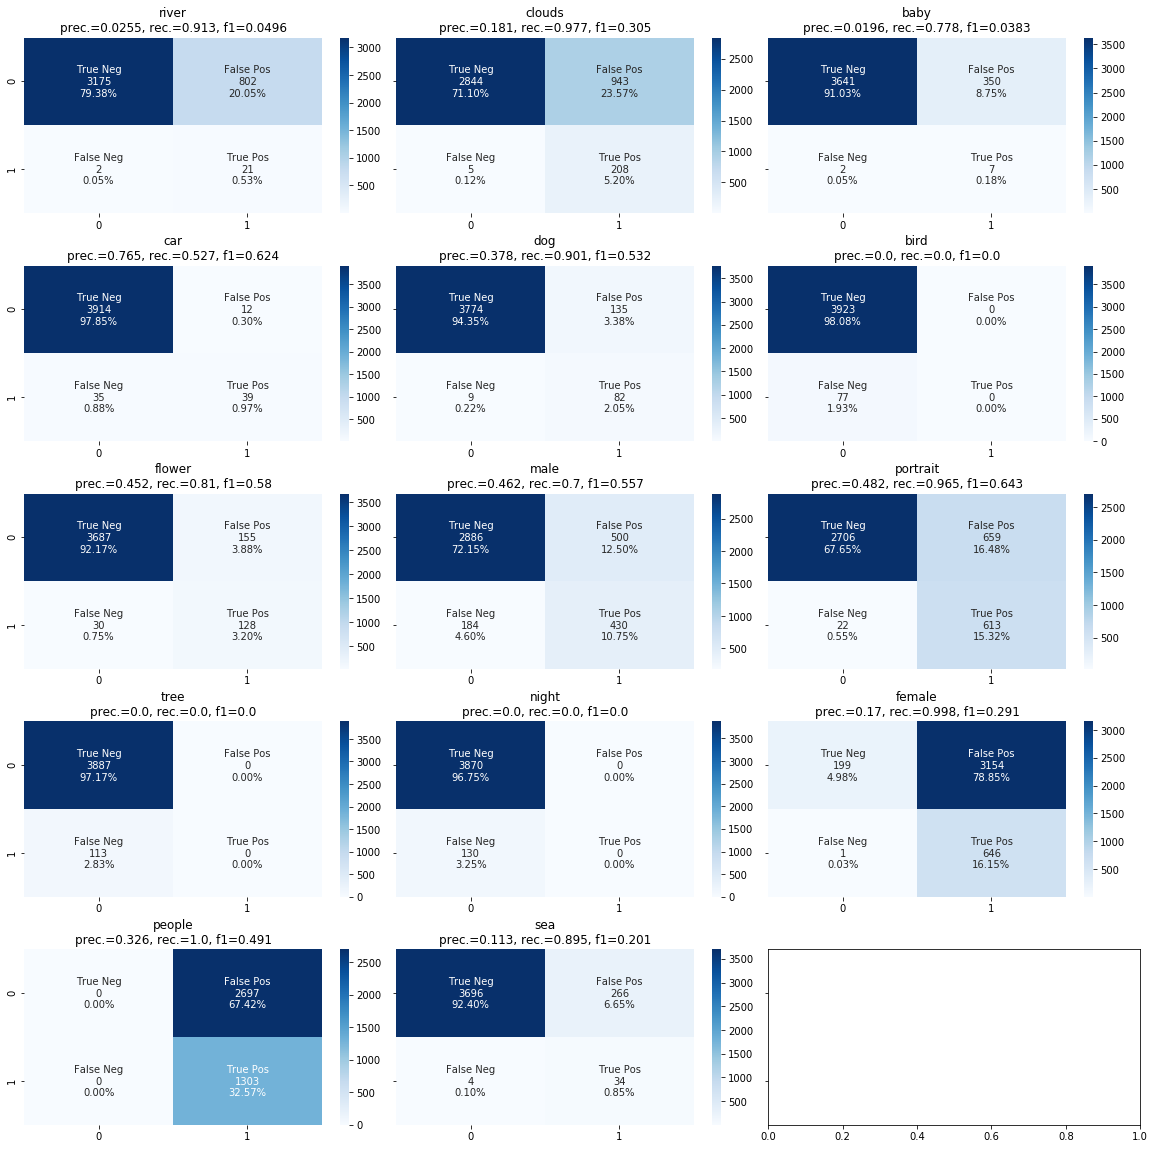

In [38]:
# Show confus|ion matrix plot
IPython_Image(filename=f'../data/valid_confusion_matrix.png', width=1000)